In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
# import optperfprofpy

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2
from subprocess import call

import tensorflow as tf

warnings.filterwarnings('ignore')
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
# o0 = pd.read_csv('../data/1320_feature/features_v11.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
#                  usecols=lambda col: col not in ['d_vlt'])
with open('../data/1320_feature/df_e2e.pkl', 'rb') as fp:
    o0 = pickle.load(fp)
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [3]:
o0 = o0[o0.next_complete_dt < dt.datetime(2018,8,31)]

In [4]:
o0[o0['item_sku_id']=='6450270#10']
#4285528#3

,item_sku_id,pur_bill_id,item_first_cate_cd,item_second_cate_cd,brand_code,create_day_of_week,create_tm,complete_dt,dt,vlt_actual,...,item_third_cate_cd_5022,item_third_cate_cd_5024,int_org_num_3,int_org_num_4,int_org_num_5,int_org_num_6,int_org_num_9,int_org_num_10,int_org_num_316,int_org_num_772
120461,6450270#10,54027902,1320,1584,193767,3,2018-07-03 12:48:48,2018-07-06 17:19:13,2018-09-08,3.187789,...,0,0,0,0,0,0,0,1,0,0
120462,6450270#10,54184997,1320,1584,193767,5,2018-07-05 04:55:40,2018-07-06 17:19:11,2018-09-08,1.516331,...,0,0,0,0,0,0,0,1,0,0
120463,6450270#10,54481105,1320,1584,193767,2,2018-07-09 05:14:59,2018-07-11 18:30:59,2018-09-08,2.552778,...,0,0,0,0,0,0,0,1,0,0
120464,6450270#10,54778065,1320,1584,193767,4,2018-07-11 18:41:26,2018-07-14 15:02:02,2018-09-08,2.847639,...,0,0,0,0,0,0,0,1,0,0
120465,6450270#10,56098750,1320,1584,193767,4,2018-07-25 04:56:00,2018-07-27 16:46:57,2018-09-08,2.493715,...,0,0,0,0,0,0,0,1,0,0
120466,6450270#10,56582259,1320,1584,193767,2,2018-07-30 05:07:00,2018-08-03 18:18:08,2018-09-08,4.549398,...,0,0,0,0,0,0,0,1,0,0
120467,6450270#10,56832803,1320,1584,193767,4,2018-08-01 04:55:20,2018-08-03 17:19:06,2018-09-08,2.516505,...,0,0,0,0,0,0,0,1,0,0
120468,6450270#10,57288705,1320,1584,193767,2,2018-08-06 05:05:57,2018-08-08 18:06:53,2018-09-08,2.542315,...,0,0,0,0,0,0,0,1,0,0
120469,6450270#10,57559925,1320,1584,193767,4,2018-08-08 05:01:30,2018-08-11 17:04:04,2018-09-08,3.501782,...,0,0,0,0,0,0,0,1,0,0
120470,6450270#10,58063101,1320,1584,193767,2,2018-08-13 05:14:56,2018-08-17 15:42:36,2018-09-08,4.435880,...,0,0,0,0,0,0,0,1,0,0


In [5]:
o0.groupby('item_sku_id').pur_bill_id.count().sort_values(ascending=False)[2000:2001]

item_sku_id
5045816#6    8
Name: pur_bill_id, dtype: int64

In [6]:
o0.shape

(93362, 156)

In [7]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [8]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 
#     'brand_code', 
#     'create_day_of_week'
    ]

VLT_FEA = [
#            'review_period', 
    'uprc', 'contract_stk_prc', 
    'wt', 'width', 'height', 'calc_volume', 'len',
    'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
    'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
    'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
    'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
    'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
    'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
    'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
    'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
        'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
        'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
        'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
        'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
        'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
        'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
        'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
        'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
        'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
        'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
        'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
        'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
           'normal', 
           'gamma', 
            'eq'
            ]

IS_FEA = [
           'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']  
    
CAT_FEA_HOT = ['item_third_cate_cd_1591',
             'item_third_cate_cd_2677',
             'item_third_cate_cd_5022',
             'item_third_cate_cd_5024',
             'int_org_num_3',
             'int_org_num_4',
             'int_org_num_5',
             'int_org_num_6',
             'int_org_num_9',
             'int_org_num_10',
             'int_org_num_316',
             'int_org_num_772']
TO_SCALE = [
            # 'label_sf'
            ]
SEQ2SEQ = ['Enc_X', 'Enc_y', 'Dec_X', 'Dec_y']

LABEL = ['demand_RV']    
LABEL_vlt = ['vlt_actual']    
LABEL_sf = ['label_sf'] 

In [9]:
SCALE_FEA =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA + CAT_FEA_HOT + TO_SCALE + LABEL_vlt + LABEL_sf
CUT_FEA = VLT_FEA + SF_FEA + MORE_FEA
MODEL_FEA = VLT_FEA + SF_FEA + MORE_FEA + IS_FEA + CAT_FEA_HOT

In [10]:
sku_set = o0.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=12, train_size=0.9, test_size=0.1)
# with open('../data/1320_feature/sku_buddle.pkl', 'rb') as fp:
#     sku_train, sku_test = pickle.load(fp)
df_train = o0[(o0['sku_id'].isin(sku_train)) & (o0['create_tm'] < dt.datetime(2018,7,27))]
df_test = o0[(o0['sku_id'].isin(sku_test)) & (o0['create_tm'] >= dt.datetime(2018,7,27))]
# df_train = o0[o0['create_tm'] < dt.datetime(2018,8,10)]
# df_test = o0[o0['create_tm'] >= dt.datetime(2018,8,10)]

In [11]:
df_train.shape, df_test.shape

((46574, 156), (3753, 156))

In [12]:
X_train_ns, y_train_ns, id_train = df_train[SCALE_FEA], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[SCALE_FEA], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [13]:
# y_train_ns = np.log(y_train_ns+1)
# y_test_ns = np.log(y_test_ns+1)

In [14]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

22.487537620622177 22.337129153819806


In [15]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)
# y_train = y_train_ns

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# y_test = y_test_ns

# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [16]:
pd_scaler = pd.concat([pd.DataFrame([y_scaler.data_min_,y_scaler.scale_], columns=y_train_ns.columns),
            pd.DataFrame([X_scaler.data_min_,X_scaler.scale_], columns=X_train_ns.columns)], axis=1)
pd_scaler.to_csv('../data/1320_feature/scaler.csv', index=False)

In [17]:
pd_scaler = pd.read_csv('../data/1320_feature/scaler.csv')
pd_scaler.loc[1, 'label_sf']

0.00020606312609925824

In [18]:
X_train = X_train[MODEL_FEA]
X_test = X_test[MODEL_FEA]

In [19]:
cat_dim = len(CAT_FEA_HOT)
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim =  vlt_dim + sf_dim + oth_dim + is_dim + cat_dim

hidden_dim = [[100, 120], 160, 30]

output_dim = 1
q = 0.7


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_cat = tf.placeholder(tf.float32, shape=[None, cat_dim], name='Input_pf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    mean_vlt = tf.expand_dims(x_vlt[:,-17],1, name='mean_vlt')
    review_p = tf.expand_dims(x_oth[:,0],1, name='review_p')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim+cat_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(tf.concat([x_vlt, x_cat], axis=1), W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim+cat_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Bias_1_sf')
    l1_sf = tf.add(tf.matmul(tf.concat([x_sf, x_cat], axis=1), W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)
            
# with tf.variable_scope('Layer_1_profile'):
#     W1_pf = tf.Variable(tf.truncated_normal([cat_dim, hidden_dim[0][2]], stddev=0.001), name='Weight_1_pf')
#     b1_pf = tf.Variable(tf.zeros([hidden_dim[0][2]]), name='Bias_1_pf')
#     l1_pf = tf.add(tf.matmul(x_cat, W1_pf), b1_pf)
#     l1_pf = tf.nn.relu(l1_pf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1]+oth_dim, hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf, x_oth], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    c_os = q*error
    c_hd = (q-1)*error
    loss = tf.reduce_mean(tf.maximum(c_os, c_hd) )
#     c_os = tf.maximum(tf.zeros([1], tf.float32), q*error)
#     c_hd = tf.multiply((1-q)*output, review_p + mean_vlt )*0.5
#     loss = tf.reduce_mean(c_os+ c_hd )    

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [20]:
epochs = 40
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_cat: X_train[CAT_FEA_HOT].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_cat: X_test[CAT_FEA_HOT].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_data_ns = X_train_ns.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_cat: batch_data[CAT_FEA_HOT].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_cat: X_test[CAT_FEA_HOT].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.027599728 0.026070634
1 0.011234617192051335 0.006029941
2 0.006658378189569457 0.005710851
3 0.006423426984163088 0.005581238
4 0.00621881229282774 0.005510953
5 0.005996013627046321 0.0054539223
6 0.005795046934334373 0.005427299
7 0.005640765138857258 0.0053581055
8 0.005532754871718464 0.0053057713
9 0.005427532460076692 0.0052606165
10 0.005364845430889744 0.005229111
11 0.005317082157927311 0.005199994
12 0.005263299789797932 0.0051993714
13 0.005232422561766073 0.0051627145
14 0.005185186534741034 0.005150999
15 0.005149556059110673 0.005125334
16 0.005115560067126645 0.0051047658
17 0.005066368771348934 0.0050701452
18 0.005034712754788987 0.005030021
19 0.00498729231130664 0.0050134766
20 0.004954088571084953 0.004957564
21 0.004916843387665464 0.004939968
22 0.004882212554931246 0.0049134647
23 0.004845778619603069 0.004900526
24 0.004811936565308303 0.0048717298
25 0.004790137532715764 0.0048250854
26 0.004755019455167593 0.0048300647
27 0.004731925145616184 0.0048014363

In [119]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_cat: X_test[CAT_FEA_HOT].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['E2E_NN_pred']).fillna(0)
# pred = pd.DataFrame(np.exp(pred)-1, columns=['prediction']).fillna(0)

In [111]:
pred_path = '../logs/torch/pred_v5.csv'
pred_v5 = pd.read_csv(pred_path)
pred_path = '../logs/torch/pred_v6.csv'
pred_v6 = pd.read_csv(pred_path)
sf_rnn = pickle.load(open('../logs/torch/pred_E2E_SF_RNN.pkl', 'rb'))

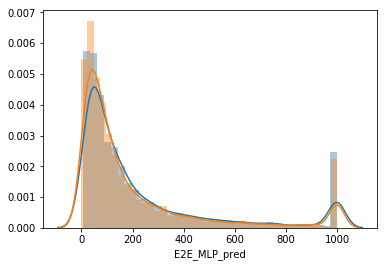

In [112]:
sns.distplot(pred_v5['E2E_MLP_pred'].clip(0,1000));
sns.distplot(y_test_ns.clip(0,1000));

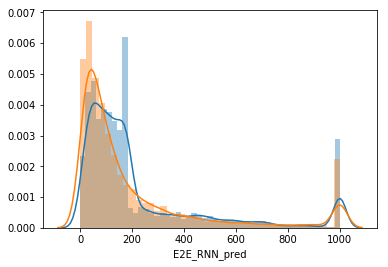

In [114]:
sns.distplot(pred_v6['E2E_RNN_pred'].clip(0,1000));
sns.distplot(y_test_ns.clip(0,1000));

In [24]:
X_train_gbm_ns = df_train[SCALE_FEA].reset_index(drop=True)
X_test_gbm_ns = df_test[SCALE_FEA].reset_index(drop=True)
y_train_gbm_ns = (df_train[['target_decision']]).clip(0)
y_test_gbm_ns = (df_test[['target_decision']]).clip(0)

X_scaler_gbm = MinMaxScaler() 
y_scaler_gbm = MinMaxScaler() 
X_train_gbm = pd.DataFrame(X_scaler_gbm.fit_transform(X_train_gbm_ns), columns=X_train_gbm_ns.columns)
y_train_gbm = pd.DataFrame(y_scaler_gbm.fit_transform(y_train_gbm_ns), columns=y_train_gbm_ns.columns)
X_test_gbm = pd.DataFrame(X_scaler_gbm.transform(X_test_gbm_ns), columns=X_test_gbm_ns.columns)
y_test_gbm = pd.DataFrame(y_scaler_gbm.transform(y_test_gbm_ns), columns=y_test_gbm_ns.columns)
X_train_gbm = X_train_gbm[MODEL_FEA]
X_test_gbm = X_test_gbm[MODEL_FEA]

In [25]:
gbm = lgb.LGBMRegressor(alpha=0.8, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=100, 
                        subsample=0.7,
                        reg_sqrt = True,
                        silent=1,
                        seed=0)

gbm.fit(X_train_gbm, y_train_gbm['target_decision']) 

LGBMRegressor(alpha=0.8, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='quantile',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, reg_sqrt=True,
       seed=0, silent=1, subsample=0.7, subsample_for_bin=200000,
       subsample_freq=0)

In [26]:
gbm_pred=gbm.predict(X_test_gbm) 

gbm_pred = pd.DataFrame(y_scaler_gbm.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['E2E_GBM_pred']).fillna(0).clip(0)
gbm_pred.E2E_GBM_pred = gbm_pred.E2E_GBM_pred+X_test_gbm_ns.initial_stock

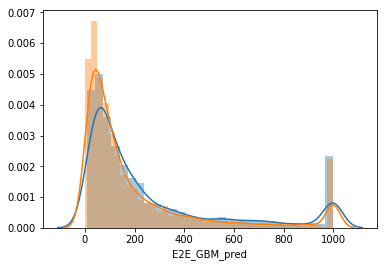

In [27]:
sns.distplot(gbm_pred['E2E_GBM_pred'].clip(0,1000));
sns.distplot(y_test_ns.clip(0,1000));

In [28]:
h = 1
b = 9

In [29]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)

In [30]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [115]:
list_c = ['SKU_DC', 'create_tm', 'OPT', 
#           'E2E_NN',
          'E2E_MLP', 'E2E_RNN',
          'E2E_GBM',  
          'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [116]:
df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [117]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]

Z90 = 1.96
o4['OPT_inv_f'], o4['OPT_inv'] = zip(*o4.apply(lambda x: get_inv(x, 'target_decision'), axis=1))

o4['EQ_pred'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_replen'] = (o4['EQ_pred'] - o4['initial_stock']).clip(0)
o4['EQ_inv_f'], o4['EQ_inv'] = zip(*o4.apply(get_inv, name='EQ_replen', axis=1))

o4['Normal_pred'] = o4.apply(lambda x: int(x['mean_112']*1.1*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)
o4['Normal_replen'] = (o4['Normal_pred'] - o4['initial_stock']).clip(0)
o4['Normal_inv_f'], o4['Normal_inv'] = zip(*o4.apply(get_inv, name='Normal_replen',  axis=1))

def gamma_base(x):
    mean = x['mean_112']*1.2
    var = x['std_140']**2
    theta = var/(mean+1e-4)
    k = mean/(theta+1e-4)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_pred'] = o4.apply(gamma_base, axis=1)
o4['Gamma_replen'] = (o4['Gamma_pred'] - o4['initial_stock']).clip(0)
o4['Gamma_inv_f'],o4['Gamma_inv'] = zip(*o4.apply(get_inv, name='Gamma_replen', axis=1))

o4['Hist_inv_f'], o4['Hist_inv'] = zip(*o4.apply(get_inv, name='actual_pur_qtty', axis=1))

In [34]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'] = o4['EQ_replen_with_IS'] - o4['initial_stock_overall']
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
# o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [120]:
o4['E2E_GBM_replen'] = (gbm_pred['E2E_GBM_pred'] - o4['initial_stock']).clip(0)
o4['E2E_GBM_inv_f'], o4['E2E_GBM_inv'] = zip(*o4.apply(get_inv, name='E2E_GBM_replen',  axis=1))

o4['E2E_NN_replen'] = (pred['E2E_NN_pred'] - o4['initial_stock']).clip(0)
o4['E2E_NN_inv_f'], o4['E2E_NN_inv'] = zip(*o4.apply(get_inv, name='E2E_NN_replen', axis=1))

o4['E2E_MLP_replen'] = (pred_v5['E2E_MLP_pred'] - o4['initial_stock']).clip(0)
o4['E2E_MLP_inv_f'], o4['E2E_MLP_inv'] = zip(*o4.apply(get_inv, name='E2E_MLP_replen', axis=1))

o4['E2E_RNN_replen'] = (pred_v6['E2E_RNN_pred'] - o4['initial_stock']).clip(0)
o4['E2E_RNN_inv_f'], o4['E2E_RNN_inv'] = zip(*o4.apply(get_inv, name='E2E_RNN_replen', axis=1))

In [121]:
str_list = ['OPT', 
#             'E2E_NN', 
            'E2E_MLP', 'E2E_RNN', 
            'E2E_GBM', 
            'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_14']
                                  if np.mean(x['mean_14']) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [37]:
# h,b = 1,9
# str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'Normal', 'Gamma', 'Hist']
# o4['OPT_replen'] = o4['target_decision']
# o4['Hist_replen'] = o4['actual_pur_qtty']
# for str1 in str_list:
#     str_r = str1 + '_replen'
#     str2 = str1 + '_inv'
#     df_holding[str1] = (o4[str_r] - o4['target_decision']).clip(0) * h
#     df_back[str1] = (o4['target_decision'] - o4[str_r]).clip(0) * b
#     df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
#     df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112']
#                                   if np.mean(x['mean_112']) >0 else np.mean(x[str2]), axis=1).fillna(7)
#     df_cost[str1] = df_holding[str1] + df_back[str1]

In [122]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

,E2E_MLP,Hist,E2E_RNN,E2E_GBM,Gamma,Normal
Best,0.472156,0.210765,0.139622,0.082068,0.056222,0.039169


In [123]:
df_com = pd.DataFrame({'Total Cost' : df_cost[str_list].mean(),
             'Holding Cost': df_holding[str_list].mean(),
             'Stockout Cost': df_back[str_list].mean(),
             'Stockout rate': df_stockout[str_list].mean(),
             'Turnover rate': df_turnover[str_list].mean(),
             }).T
df_com

,OPT,E2E_MLP,E2E_RNN,E2E_GBM,Normal,Gamma,Hist
Total Cost,733.468159,998.094542,950.955252,1047.075736,1693.687184,1555.624567,1236.368505
Holding Cost,659.209166,883.488351,817.522132,933.395477,1661.190781,1510.847589,1022.428457
Stockout Cost,74.258993,114.606191,133.433120,113.680259,32.496403,44.776978,213.940048
Stockout rate,0.074379,0.130017,0.095939,0.082177,0.039539,0.059441,0.188516
Turnover rate,4.688122,6.766950,8.321740,8.707426,14.515929,12.502682,7.612045


In [290]:
list_c2 = ['SKU_DC',
#           'E2E_NN',
          'E2E_MLP', 'E2E_RNN',
          'Bm1','Bm2',  
          'Ave_sales','Std_sales'
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df2_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)

In [291]:
df2_cost['SKU_DC']=df2_holding['SKU_DC']=df2_back['SKU_DC']=df2_stockout['SKU_DC']=df2_turnover['SKU_DC']=o4['item_sku_id'].values
df2_cost['Ave_sales']=df2_holding['Ave_sales']=df2_back['Ave_sales']=df2_stockout['Ave_sales']=df2_turnover['Ave_sales']=o4['mean_112'].values
df2_cost['Std_sales']=df2_holding['Std_sales']=df2_back['Std_sales']=df2_stockout['Std_sales']=df2_turnover['Std_sales']=o4['std_140'].values

In [343]:
o4['Bm1_pred'] = np.mean(sf_rnn[:,:,5], axis=1)
o4['Bm1_pred'] = o4['Bm1_pred'] * (o4['review_period'] + o4['vlt_actual']).astype(int)

def get_bm2(x):
    rl = x['review_period'] + x['vlt_actual']
    if rl <= b:
        days = int(rl)
    else:
        days = int(rl) - rl//(b+h)
    return x['Bm2_pred'] * days

o4['Bm2_pred'] = np.mean(sf_rnn[:,:,4], axis=1)
o4['Bm2_pred'] = o4.apply(get_bm2, axis=1)

In [344]:
o4['Bm1_replen'] = (o4['Bm1_pred'] - o4['initial_stock']).clip(0)
o4['Bm1_inv_f'], o4['Bm1_inv'] = zip(*o4.apply(get_inv, name='Bm1_replen', axis=1))

o4['Bm2_replen'] = (o4['Bm2_pred'] - o4['initial_stock']).clip(0)
o4['Bm2_inv_f'], o4['Bm2_inv'] = zip(*o4.apply(get_inv, name='Bm2_replen', axis=1))

In [345]:
str_list2 = ['E2E_MLP', 'E2E_RNN', 'Bm1','Bm2']
for str1 in str_list2:
    str2 = str1 + '_inv'
    df2_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df2_back[str1] = o4[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df2_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df2_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_14']
                                  if np.mean(x['mean_14']) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df2_cost[str1] = df2_holding[str1] + df2_back[str1]

In [346]:
pd.DataFrame({'Best': df2_cost.iloc[:,1:5].idxmin(axis=1).value_counts()/len(df2_cost)}).T

,E2E_MLP,Bm2,E2E_RNN,Bm1
Best,0.47855,0.285905,0.133493,0.102052


In [361]:
df2_cost

,SKU_DC,E2E_MLP,E2E_RNN,Bm1,Bm2,Ave_sales,Std_sales
0,258214#3,0.000000,0.000000,0.000000,0.000000,194.151786,82.417867
1,258214#3,9288.548000,12178.504000,9112.000000,9429.844635,193.794643,82.400208
2,258214#3,4687.000000,4687.000000,4687.000000,4687.000000,185.214286,82.470279
3,258214#3,4437.492500,7334.184900,6000.341125,3841.523163,178.392857,81.425470
4,258214#4,1294.584300,980.964560,1291.550476,736.085695,27.946429,11.182213
5,258214#4,0.000000,0.000000,0.000000,0.000000,27.232143,10.938478
6,258214#4,436.592200,425.965660,489.750145,768.399651,27.107143,10.964886
7,258214#4,647.214100,833.124500,1267.934448,691.738398,26.678571,10.952000
8,258214#5,1718.278340,1285.053350,2217.748211,1115.521721,37.535714,14.743527
9,258214#6,0.000000,0.000000,0.000000,0.000000,145.517857,46.866500


In [347]:
df2_com = pd.DataFrame({'Total Cost' : df2_cost[str_list2].mean(),
             'Holding Cost': df2_holding[str_list2].mean(),
             'Stockout Cost': df2_back[str_list2].mean(),
             'Stockout rate': df2_stockout[str_list2].mean(),
             'Turnover rate': df2_turnover[str_list2].mean(),
             }).T
df2_com

,E2E_MLP,E2E_RNN,Bm1,Bm2
Total Cost,998.094542,950.955252,1097.776788,925.432447
Holding Cost,883.488351,817.522132,965.026706,705.552961
Stockout Cost,114.606191,133.433120,132.750081,219.879486
Stockout rate,0.130017,0.095939,0.086059,0.185213
Turnover rate,6.766950,8.321740,9.389059,5.821450


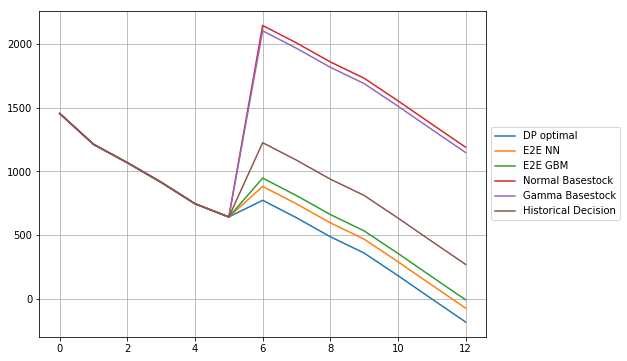

In [348]:
tt = o4.iloc[3,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_inv_f'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_inv_f'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_inv_f'], label = 'E2E GBM')
# ax1.plot(tt['EQ_inv_f'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_inv_f'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_inv_f'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_inv_f'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [349]:
o4_ = pd.concat([o4, pred, pred_v5['E2E_MLP_pred'], pred_v6['E2E_RNN_pred'], gbm_pred], axis=1)
o4_['Hist_pred'] = o4_['actual_pur_qtty'] + o4_['initial_stock']
o4_['OPT_pred'] = o4_[LABEL]
o4g = o4_.groupby('item_sku_id').agg(lambda x: x.tolist())

In [350]:
def get_agginv(x, name):
    inv1, inv2 = [x['initial_stock'][0]], []
    rd = len(x['pur_bill_id'])
 
    for r in range(rd):
        if r < rd - 1:
            len_day = len(x['demand_RV_list'][r])-1
        else:
            len_day = len(x['demand_RV_list'][r])
        for t in range(len_day):
            if t == 0:
                if r == 0:
                    replen = int(round(x[name+'_pred'][r] - inv1[0]))
                else:
                    try:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[-int(round(x['vlt_actual'][r]))-1], 0)))
                    except:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[1],0)))
            if t < int(round(x['vlt_actual'][r])):
                if r == 0:
                    inv1.append(inv1[-1] - x['demand_RV_list'][r][t])
            elif t == int(round(x['vlt_actual'][r])):
                if inv1[-1] >= 0:
                    inv_ = inv1[-1] + replen - x['demand_RV_list'][r][t]
                else:
                    inv_ = replen - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
            else:
                inv_ = inv1[-1] - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
    
    inv1 = inv1[1:]
    return [inv1, inv2]

o4g['OPT_agginv_f'], o4g['OPT_agginv'] = zip(*o4g.apply(get_agginv, name='OPT',  axis=1))
o4g['E2E_NN_agginv_f'], o4g['E2E_NN_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_NN',  axis=1))
o4g['E2E_MLP_agginv_f'], o4g['E2E_MLP_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_MLP',  axis=1))
o4g['E2E_RNN_agginv_f'], o4g['E2E_RNN_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_RNN',  axis=1))
o4g['E2E_GBM_agginv_f'], o4g['E2E_GBM_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_GBM',  axis=1))
o4g['EQ_agginv_f'], o4g['EQ_agginv'] = zip(*o4g.apply(get_agginv, name='EQ',  axis=1))
o4g['Normal_agginv_f'], o4g['Normal_agginv'] = zip(*o4g.apply(get_agginv, name='Normal',  axis=1))
o4g['Gamma_agginv_f'], o4g['Gamma_agginv'] = zip(*o4g.apply(get_agginv, name='Gamma',  axis=1))
o4g['Hist_agginv_f'], o4g['Hist_agginv'] = zip(*o4g.apply(get_agginv, name='Hist',  axis=1))

In [351]:
# xx = o4g.loc['258236#3']
# xx['OPT_agginv'], xx['OPT_pred'], xx['initial_stock'],xx['demand_RV_list']

In [352]:
list_c = ['SKU_DC', 'OPT', 
#           'E2E_NN', 
          'E2E_MLP', 'E2E_RNN', 
          'E2E_GBM', 
          'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4g)
df_cost_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

df_cost_agg['SKU_DC']=df_holding_agg['SKU_DC']=df_back_agg['SKU_DC']=df_stockout_agg['SKU_DC']\
            =df_turnover_agg['SKU_DC']=o4g.index.values
df_cost_agg['Ave_sales']=df_holding_agg['Ave_sales']=df_back_agg['Ave_sales']=df_stockout_agg['Ave_sales']\
            =df_turnover_agg['Ave_sales']=o4g['mean_112'].apply(lambda x:x[0]).values
df_cost_agg['Std_sales']=df_holding_agg['Std_sales']=df_back_agg['Std_sales']=df_stockout_agg['Std_sales']\
            =df_turnover_agg['Std_sales']=o4g['std_140'].apply(lambda x:x[0]).values

In [353]:
str_list = ['OPT', 
#             'E2E_NN', 
            'E2E_MLP', 'E2E_RNN', 
            'E2E_GBM', 
            'Normal', 'Gamma', 'Hist']
o4g_ = o4g.reset_index(drop=True)
for str1 in str_list:
    str2 = str1 + '_agginv'
    df_holding_agg[str1] = o4g_[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back_agg[str1] = o4g_[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout_agg[str1] = o4g_[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover_agg[str1] = o4g_.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112'][0]
                                  if np.mean(x['mean_112'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost_agg[str1] = df_holding_agg[str1] + df_back_agg[str1]

In [354]:
pd.DataFrame({'Best': df_cost_agg.iloc[:,2:7].idxmin(axis=1).value_counts()/len(df_cost)}).T

,E2E_MLP,E2E_RNN,E2E_GBM,Gamma,Normal
Best,0.218758,0.140421,0.044764,0.03304,0.007194


In [355]:
df_aggcom = pd.DataFrame({'Total cost': df_cost_agg[str_list].mean(),
             'Holding cost': df_holding_agg[str_list].mean(),
             'Stockout cost': df_back_agg[str_list].mean(),
             'Stockout rate': df_stockout_agg[str_list].mean(),
             'Turnover rate': df_turnover_agg[str_list].mean(),
             }).T
df_aggcom

,OPT,E2E_MLP,E2E_RNN,E2E_GBM,Normal,Gamma,Hist
Total cost,1768.502100,2463.115777,2303.483503,3025.090582,4636.819436,4196.594481,3324.155369
Holding cost,1626.418716,2275.595081,2072.782244,2962.349730,4468.832034,3993.616677,3237.848230
Stockout cost,142.083383,187.520696,230.701260,62.740852,167.987403,202.977804,86.307139
Stockout rate,0.033749,0.093084,0.082066,0.033153,0.029233,0.042361,0.091591
Turnover rate,7.776102,10.349857,12.707137,13.787155,19.798418,17.116164,11.256141


In [356]:
o4g['Bm1_agginv_f'], o4g['Bm1_agginv'] = zip(*o4g.apply(get_agginv, name='Bm1',  axis=1))
o4g['Bm2_agginv_f'], o4g['Bm2_agginv'] = zip(*o4g.apply(get_agginv, name='Bm2',  axis=1))

In [357]:
numberOfRows = len(o4g)
df2_cost_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_holding_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_back_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_stockout_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_turnover_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)

df2_cost_agg['SKU_DC']=df2_holding_agg['SKU_DC']=df2_back_agg['SKU_DC']=df2_stockout_agg['SKU_DC']\
            =df2_turnover_agg['SKU_DC']=o4g.index.values
df2_cost_agg['Ave_sales']=df2_holding_agg['Ave_sales']=df2_back_agg['Ave_sales']=df2_stockout_agg['Ave_sales']\
            =df2_turnover_agg['Ave_sales']=o4g['mean_112'].apply(lambda x:x[0]).values
df2_cost_agg['Std_sales']=df2_holding_agg['Std_sales']=df2_back_agg['Std_sales']=df2_stockout_agg['Std_sales']\
            =df2_turnover_agg['Std_sales']=o4g['std_140'].apply(lambda x:x[0]).values

In [358]:
o4g_ = o4g.reset_index(drop=True)
for str1 in str_list2:
    str2 = str1 + '_agginv'
    df2_holding_agg[str1] = o4g_[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df2_back_agg[str1] = o4g_[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df2_stockout_agg[str1] = o4g_[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df2_turnover_agg[str1] = o4g_.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112'][0]
                                  if np.mean(x['mean_112'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df2_cost_agg[str1] = df2_holding_agg[str1] + df2_back_agg[str1]

In [359]:
pd.DataFrame({'Best': df2_cost_agg.iloc[:,1:5].idxmin(axis=1).value_counts()/len(df2_cost)}).T

,Bm2,E2E_MLP,E2E_RNN,Bm1
Best,0.242206,0.123102,0.061018,0.017852


In [360]:
df2_aggcom = pd.DataFrame({'Total cost': df2_cost_agg[str_list2].mean(),
             'Holding cost': df2_holding_agg[str_list2].mean(),
             'Stockout cost': df2_back_agg[str_list2].mean(),
             'Stockout rate': df2_stockout_agg[str_list2].mean(),
             'Turnover rate': df2_turnover_agg[str_list2].mean(),
             }).T
df2_aggcom

,E2E_MLP,E2E_RNN,Bm1,Bm2
Total cost,2463.115777,2303.483503,2586.570486,1858.477504
Holding cost,2275.595081,2072.782244,2314.556689,1499.298140
Stockout cost,187.520696,230.701260,272.013797,359.179364
Stockout rate,0.093084,0.082066,0.069879,0.153521
Turnover rate,10.349857,12.707137,14.644203,8.443878


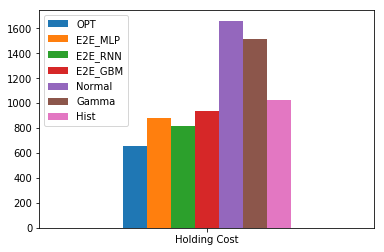

In [342]:
df_com.iloc[1:2,:].plot.bar(rot=0)
plt.savefig('../figures/eps/exp1.eps', dpi=200)

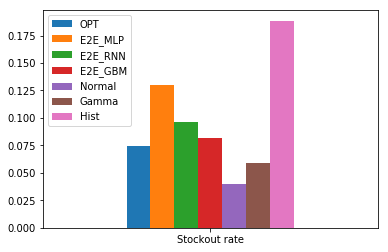

In [161]:
df_com.iloc[3:4,:].plot.bar(rot=0)
plt.savefig('../figures/eps/exp2.eps', dpi=200)

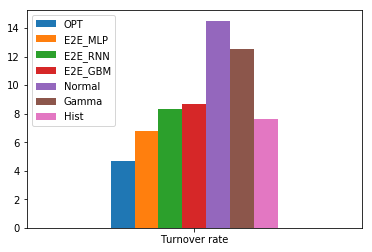

In [162]:
df_com.iloc[4:5,:].plot.bar(rot=0)
plt.savefig('../figures/eps/exp3.eps', dpi=200)

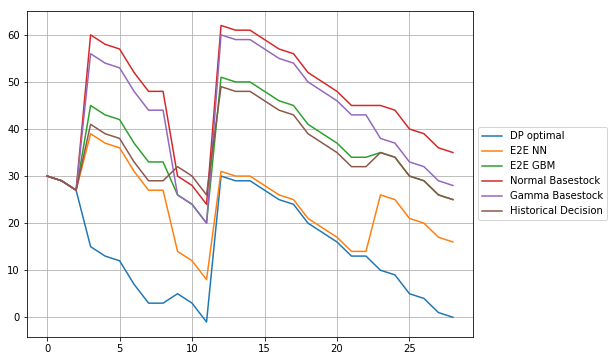

In [48]:
tt = o4g.iloc[114,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_agginv_f'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_agginv_f'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_agginv_f'], label = 'E2E GBM')
# ax1.plot(tt['EQ_agginv_f'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_agginv_f'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_agginv_f'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_agginv_f'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [49]:
import matplotlib.pyplot as plt
import matplotlib

In [50]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

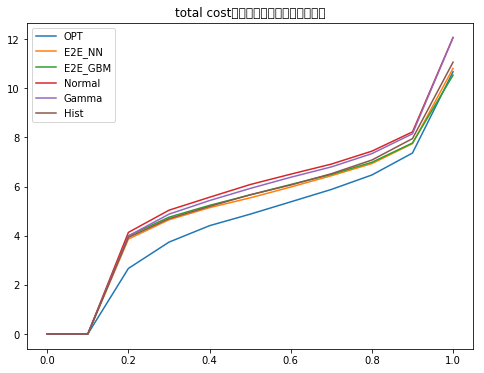

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('total cost不同分位点下不同模型的表现');

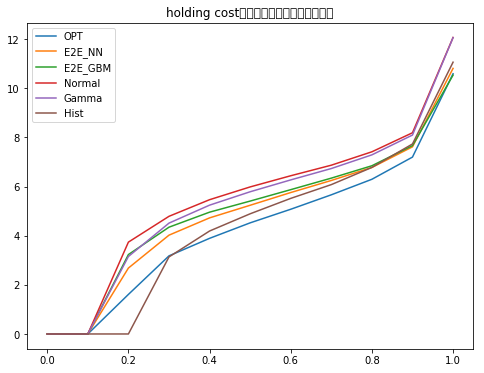

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

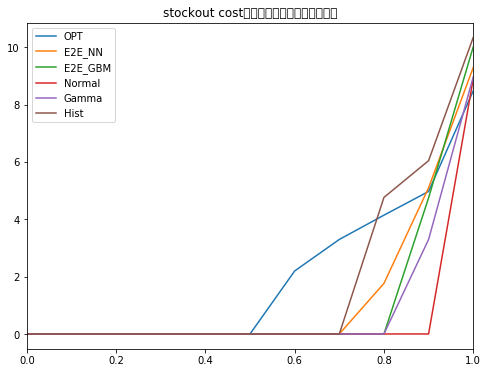

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('stockout cost不同分位点下不同模型的表现');

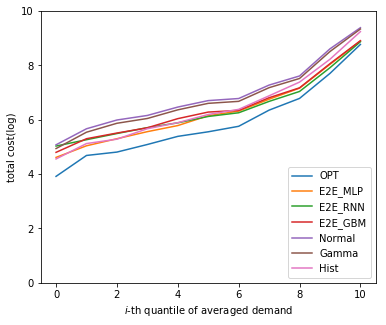

In [163]:
sl_qtl = df_cost.sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.log(sl_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaged demand');
ax.set_ylabel('total cost(log)');
ax.set_ylim((0,10));
plt.savefig('../figures/eps/qtl1.eps', dpi=200)

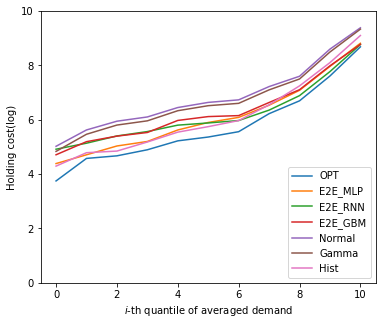

In [164]:
sl_qtl = df_holding.sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.log(sl_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaged demand');
ax.set_ylabel('Holding cost(log)');
ax.set_ylim((0,10));
plt.savefig('../figures/eps/qtl2.eps', dpi=200)

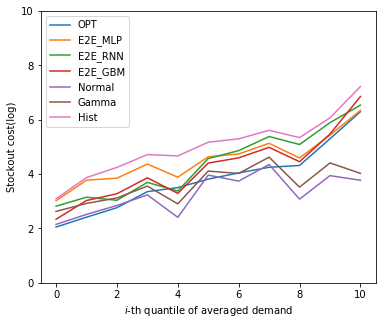

In [165]:
sl_qtl = df_back.sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.log(sl_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaged demand');
ax.set_ylabel('Stockout cost(log)');
ax.set_ylim((0,10));
plt.savefig('../figures/eps/qtl3.eps', dpi=200)

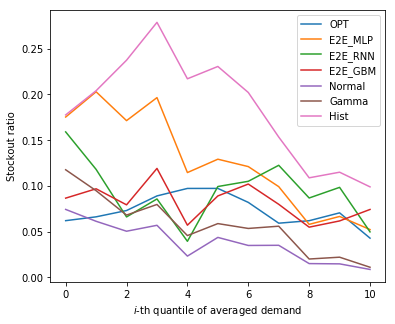

In [166]:
sl_qtl = df_stockout.sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sl_qtl.iloc[:,:-2].astype(float));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaged demand');
ax.set_ylabel('Stockout ratio');
# ax.set_ylim((0,));
plt.savefig('../figures/eps/qtl4.png', dpi=200)

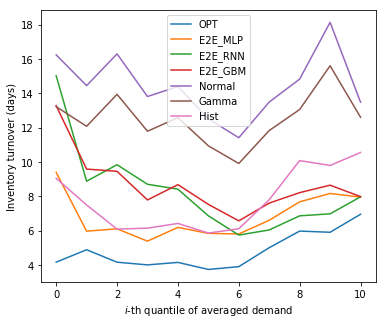

In [167]:
sl_qtl = df_turnover.sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sl_qtl.iloc[:,:-2].astype(float));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaged demand');
ax.set_ylabel('Inventory turnover (days)');
# ax.set_ylim((0,));
plt.savefig('../figures/eps/qtl5.eps', dpi=200)

In [129]:
df_cost.to_csv('../figures/eps/df_cost.csv', index=False)
df_holding.to_csv('../figures/eps/df_holding.csv', index=False)
df_back.to_csv('../figures/eps/df_back.csv', index=False)
df_stockout.to_csv('../figures/eps/df_stockout.csv', index=False)
df_turnover.to_csv('../figures/eps/df_turnover.csv', index=False)

In [59]:
# py_pp = df_cost
# py_pp['SKU_DC'] = py_pp[['SKU_DC','create_tm']].apply(lambda x: '_'.join([str(i) for i in x]), axis=1)
# py_pp.drop(columns=['create_tm','Ave_sales','Std_sales'], inplace=True)
# py_pp_stack = py_pp.set_index('SKU_DC').stack().rename('method')
# py_pp_stack = pd.DataFrame(py_pp_stack).reset_index()
# taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(py_pp_stack.iloc[0:770,:], ['SKU_DC'], ['method'], ['level_1'])
# optperfprofpy.draw_simple_pp(taus, solver_vals, solvers)

In [60]:
# import shap
# # print the JS visualization code to the notebook
# shap.initjs()

In [61]:
# explainer = shap.TreeExplainer(gbm)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)

# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
xx = np.arange(0, 200, 5)
tt_is = X_test_ns.iloc[305:306,:]
yy1, yy2 = [],[]
for i in xx:
#     tt_is['initial_stock'] = i
    tt_ = pd.DataFrame(X_scaler.transform(tt_is), columns=tt_is.columns)

    gbm_pred=gbm.predict(tt_) 
    nn_pred=sess.run(output, feed_dict={x_vlt: tt_[VLT_FEA].values, 
                                  x_sf: tt_[SF_FEA].values, 
                                  x_oth: tt_[MORE_FEA].values, 
                                  x_cat: tt_[CAT_FEA_HOT].values, 
                                  x_is: tt_[IS_FEA].values, 
                                  })
    yy1.append( y_scaler.inverse_transform(gbm_pred.reshape(-1, 1))[0][0] )
    yy2.append( y_scaler.inverse_transform(nn_pred.reshape(-1, 1))[0][0] )

fig, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(xx, yy1, label='GBM');
plt.plot(xx, yy2, label='NN');
plt.plot(xx, 350-xx, label='ideally');

# plt.plot(xx, 330-xx)
plt.xlabel('initial stock')
plt.ylabel('prediction')
plt.legend(prop={'size': 12})

In [ ]:
sess.close()

In [ ]:
# def get_agginv(x, name):
#     inv1, inv2 = [x['initial_stock'][0]], []
#     rd = len(x['pur_bill_id'])
 
#     for r in range(rd):
#         if r < rd - 1:
#             len_day = len(x['demand_RV_list'][r])-1
#         else:
#             len_day = len(x['demand_RV_list'][r])
#         print(x['demand_RV_list'][r])
#         for t in range(len_day):
#             if t == 0:
#                 if r == 0:
#                     replen = int(round(x[name+'_pred'][r] - inv1[0]))
#                 else:
#                     try:
#                         replen = int(round(x[name+'_pred'][r] - max(inv1[-int(round(x['vlt_actual'][r]))-1], 0)))
#                     except:
#                         replen = int(round(x[name+'_pred'][r] - max(inv1[1],0)))
#                 print(replen)
#             if t < int(round(x['vlt_actual'][r])):
#                 if r == 0:
#                     inv1.append(inv1[-1] - x['demand_RV_list'][r][t])
#             elif t == int(round(x['vlt_actual'][r])):
#                 if inv1[-1] >= 0:
#                     inv_ = inv1[-1] + replen - x['demand_RV_list'][r][t]
#                 else:
#                     inv_ = replen - x['demand_RV_list'][r][t]
#                 inv1.append(inv_)
#                 inv2.append(inv_)
#             else:
#                 inv_ = inv1[-1] - x['demand_RV_list'][r][t]
#                 inv1.append(inv_)
#                 inv2.append(inv_)
    
#     inv1 = inv1[1:]
#     return [inv1, inv2]

# o4g.iloc[109:110].apply(get_agginv, name='OPT',  axis=1).values

In [221]:
dic_sku_name = pickle.load(open('../../general_data/dic_sku_name.pkl', 'rb'))

                       良品铺子 西瓜子 话梅味 袋装炒货 零食小包装105g


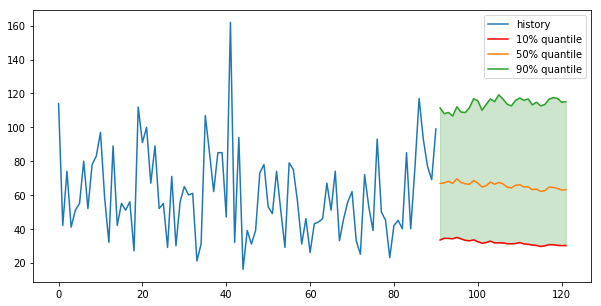

In [240]:
idx = 1000
hist = np.exp(df_test['Enc_y'].iloc[idx][0])-1
q10 = sf_rnn[idx,:,0]
q50 = sf_rnn[idx,:,2]
q90 = sf_rnn[idx,:,-2]
x1 = np.arange(91)
x2 = np.arange(91,122)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x1, hist, label='history')
ax.plot(x2, q10, color='r', label='10% quantile')
ax.plot(x2, q50, color='C1', label='50% quantile')
ax.plot(x2, q90, color='C2', label='90% quantile')
ax.fill_between(x2, q10, q90, color='g', alpha=0.2)
ax.legend()
sku = df_test.iloc[idx][0].split('#')[0]
print('                      ', dic_sku_name[sku]);